In [1]:
!pip install catboost
!pip install shap
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.2 MB/s eta 0:00:00


# 라이브러리

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap
import optuna
import warnings

# 데이터

In [3]:
data_full = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/tree_data_5m.csv")

In [4]:
data_full.head()

,Movie_Title,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,...,e248,e249,e250,e251,e252,e253,e254,e255,e256,target
0,1987,14.460909,4.255117,14.579685,4.205015,0.781548,0.633689,13.168432,8.538270,13.045756,...,-0.029663,0.010803,-0.002991,-0.047607,0.010498,-0.006042,0.010986,0.033936,0.011536,1
1,2012,14.298959,4.768491,14.311517,4.260173,0.990697,0.612752,13.159393,8.206174,12.991571,...,0.016968,0.008972,-0.022339,-0.015747,-0.014832,-0.031982,-0.008484,0.036865,-0.003265,1
2,감시자들,14.388882,4.346355,14.377501,4.123232,0.806430,0.563800,13.174882,8.550338,12.896937,...,-0.032227,-0.009277,0.001450,-0.076172,-0.017090,-0.003510,-0.013000,0.029785,0.007996,1
3,검사외전,15.016531,4.447146,15.372975,4.360212,0.939867,0.673698,13.664691,9.073260,13.625407,...,-0.017944,-0.008667,-0.003723,-0.052490,-0.030151,-0.022339,0.005646,0.015747,0.021729,2
4,검은 사제들,14.283719,4.317023,14.455399,3.881477,1.046961,0.555134,13.247543,8.695339,12.949372,...,-0.043945,-0.031006,0.002960,-0.036377,-0.032471,-0.053223,0.000710,0.042480,0.035400,1


In [5]:
print(list(data_full.columns))

['Movie_Title', 'wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Month', 'Pandemic', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'Grade', 'Main_Country', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25', 'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35', 'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45', 'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'e53', 'e54', 'e55', 'e56', 'e57', 'e58', 'e59', 'e60', 'e61', 'e62', 'e63', 'e64', 'e65', 'e66', 'e67', 'e68', 'e69', 'e70', 'e71', 'e72', 'e73', 'e74', 'e75', 'e76', 'e77', 'e78', 'e79', 'e80', 'e81', 'e82', 'e83', 'e84', 'e85', 'e86', 'e87', 'e88', 'e89', 'e90', 'e9

## 범주형 변수 지정

In [6]:
cat_features = ['Grade', 'Main_Country', 'Pandemic', 'Month']

## 데이터 분할

총 관람객 수, 총 상영일수 횟수, 총 상영 주차는 종속변수이므로 제거한다

In [7]:
movie_titles = data_full['Movie_Title']

In [8]:
X = data_full.drop(['Movie_Title', 'target'], axis=1)
y = data_full['target']
# target(y)를 기준으로 계층 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. CatBoost 사용

## 1) 초기 구동

In [9]:
model = CatBoostClassifier(
    iterations=500,
    verbose=100,  # 100번마다 학습 로그 출력
    task_type='GPU',  # GPU 사용 설정
    devices='0',       # 첫 번째 GPU 사용
    cat_features=cat_features, # 범주형 변수 지정
    auto_class_weights='Balanced' #희귀 클래스 가중치
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)

# 결과를 저장할 DataFrame 생성
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.flatten() # 1차원 배열로 변환
})

# 각 클래스의 확률을 별도의 컬럼으로 추가
results_df['Prob_Class_0'] = prediction_probs[:, 0]
results_df['Prob_Class_1'] = prediction_probs[:, 1]
results_df['Prob_Class_2'] = prediction_probs[:, 2]

# 영화 제목 추가
test_titles = movie_titles.loc[X_test.index]
results_df['Movie_Title'] = test_titles.values

Learning rate set to 0.134673
0:	learn: 0.8599792	total: 15.3ms	remaining: 7.65s
100:	learn: 0.0052785	total: 845ms	remaining: 3.34s
200:	learn: 0.0020587	total: 1.68s	remaining: 2.49s
300:	learn: 0.0011570	total: 2.5s	remaining: 1.65s
400:	learn: 0.0007576	total: 3.29s	remaining: 812ms
499:	learn: 0.0005620	total: 4.07s	remaining: 0us


In [10]:
# 결과 확인
print(results_df.head())

      Actual  Predicted  Prob_Class_0  Prob_Class_1  Prob_Class_2 Movie_Title
1340       0          0      0.999916      0.000080  4.277892e-06         하울링
1385       0          0      0.999974      0.000025  8.093067e-07        크리미널
1231       0          0      0.999966      0.000032  1.607464e-06     사랑의 레시피
1225       0          0      0.999956      0.000042  1.883687e-06        문라이트
1894       0          0      0.999949      0.000050  1.162991e-06    프라미스드 랜드


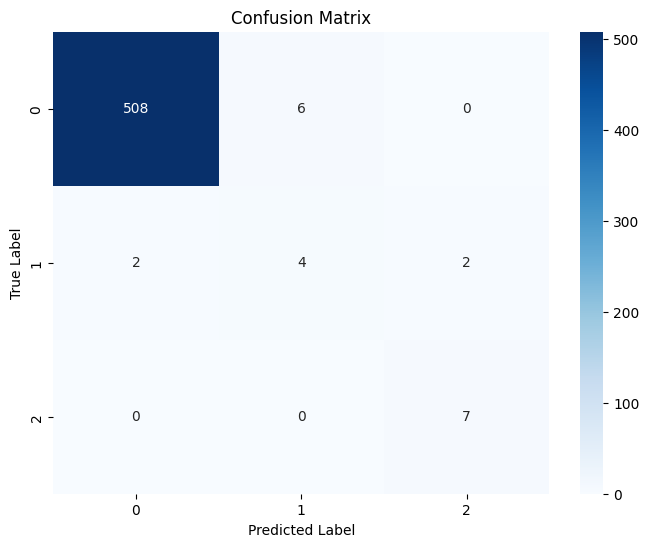

In [11]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
def calculate_multiclass_metrics(y_true, y_pred):
    """
    다중 분류 결과로부터 각 클래스별 정밀도, 재현율, 특이도를 계산합니다.
    """
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    metrics = {}

    for i in range(num_classes):
        # One-vs-Rest 관점에서 TP, FP, FN, TN 계산
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        # 정밀도 (Precision)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        # 재현율 (Recall or Sensitivity)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        # 특이도 (Specificity)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        metrics[f'Precision_Class_{i}'] = precision
        metrics[f'Recall_Class_{i}'] = recall
        metrics[f'Specificity_Class_{i}'] = specificity

    return metrics

In [13]:
calculate_multiclass_metrics(y_test, predictions)

{'Precision_Class_0': np.float64(0.996078431372549),
 'Recall_Class_0': np.float64(0.9883268482490273),
 'Specificity_Class_0': np.float64(0.8666666666666667),
 'Precision_Class_1': np.float64(0.4),
 'Recall_Class_1': np.float64(0.5),
 'Specificity_Class_1': np.float64(0.9884836852207294),
 'Precision_Class_2': np.float64(0.7777777777777778),
 'Recall_Class_2': np.float64(1.0),
 'Specificity_Class_2': np.float64(0.9961685823754789)}

## 2) 변수 중요도

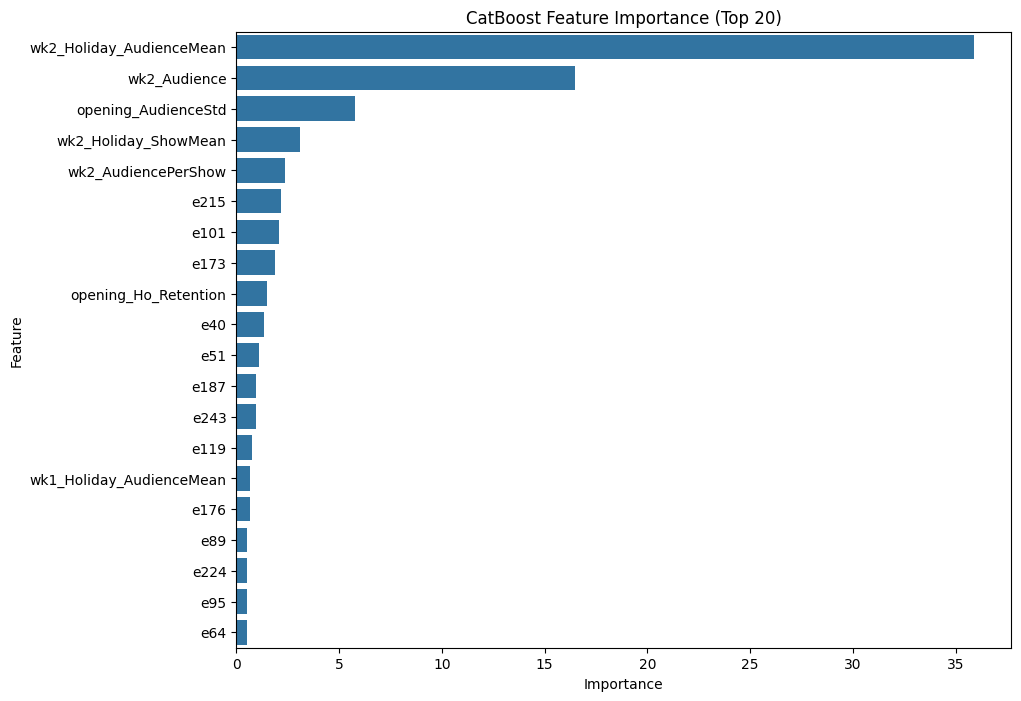

                      Feature  Importance
8    wk2_Holiday_AudienceMean   35.913078
2                wk2_Audience   16.491024
10        opening_AudienceStd    5.791006
9        wk2_Holiday_ShowMean    3.084307
3         wk2_AudiencePerShow    2.353350
233                      e215    2.180642
119                      e101    2.059146
191                      e173    1.890349
5        opening_Ho_Retention    1.481904
58                        e40    1.351839
69                        e51    1.095038
205                      e187    0.978457
261                      e243    0.966562
137                      e119    0.741450
6    wk1_Holiday_AudienceMean    0.660423
194                      e176    0.652208
107                       e89    0.531374
242                      e224    0.522214
113                       e95    0.516488
82                        e64    0.514701


In [14]:
# 1. 변수 중요도 추출
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# 2. 데이터프레임으로 만들기
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 3. 상위 20개 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance (Top 20)')
plt.show()

# 4. 중요도 출력
print(importance_df.head(20))

1. `wk2_Holiday_AudienceMean`, `wk2_Audience`
2. `opening_Ho_Retention`, `wk2_Holiday_ShowMean`, `wk2_AudiencePerShow`

총 2+3의 변수가 유의후보군

## 3) 변수 선택 및 하이퍼파라미터 튜닝

In [15]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

In [16]:
feature_sets = {
    "base_2": ['wk2_Holiday_AudienceMean', 'wk2_Audience'],
    "medium_6": ['wk2_Holiday_AudienceMean', 'wk2_Audience',
                 'opening_Ho_Retention', 'wk2_Holiday_ShowMean', 'wk2_AudiencePerShow']
}

embedding_sets = {
    "embed_128": [f'e{i+1}' for i in range(128)],
    "embed_64": [f'e{i+1}' for i in range(64)],
    "embed_32": [f'e{i+1}' for i in range(32)],
    "embed_none" : []
}

tuner_methods = ['optuna', 'random_search']
# tuner_methods = ['random_search', 'optuna']

In [ ]:
results = []
experiment_id = 0
total_experiments = len(feature_sets) * len(embedding_sets) * len(tuner_methods)

for f_name, f_cols in feature_sets.items():
    for e_name, e_cols in embedding_sets.items():

        # 현재 조합에 사용할 전체 변수 리스트 생성
        current_cols = f_cols + e_cols
        X_train_exp = X_train[current_cols]
        X_test_exp = X_test[current_cols]

        cat_features_in_use = [c for c in ['Pandemic'] if c in X_train_exp.columns]

        for tuner in tuner_methods:
            experiment_id += 1
            print(f"--- 실험 {experiment_id}/{total_experiments} 진행 중 ---")
            print(f"Features: {f_name}, Embeddings: {e_name}, Tuner: {tuner}")

            best_params = {}

            if tuner == 'optuna':
                def objective(trial):
                    param_optuna = {
                        'objective': 'MultiClass',
                        'auto_class_weights': 'Balanced',

                        'iterations': 300,
                        # 'iterations': 2,

                        'verbose' : 0,
                        'task_type': 'GPU',
                        'devices': '0',
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                        'depth': trial.suggest_int('depth', 4, 10),
                        'bootstrap_type': 'Bernoulli',
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
                        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient'])
                    }
                    model = CatBoostClassifier(**param_optuna)
                    score = cross_val_score(model, X_train_exp, y_train, cv=3, scoring='f1_macro').mean()
                    return score

                study = optuna.create_study(direction='maximize')

                study.optimize(objective, n_trials=40, n_jobs=1, show_progress_bar=True)
                # study.optimize(objective, n_trials=2, n_jobs=1, show_progress_bar=True)

                best_params = study.best_params

            elif tuner == 'random_search':
                param_random = {
                     # --- Optuna와 동일하게 확장된 하이퍼파라미터 ---
                    'learning_rate': uniform(0.01, 0.29), # 0.01부터 0.3까지 (uniform 분포)
                    'depth': randint(4, 11), # 4부터 10까지 (정수)
                    'bootstrap_type': ['Bernoulli'],
                    'subsample': uniform(0.6, 0.4), # 0.6부터 1.0까지
                    'l2_leaf_reg': uniform(1, 9), # 1부터 10까지
                    'random_strength': uniform(1, 9), # 1부터 10까지 (log 분포 대신 uniform 사용)
                    'min_child_samples': randint(5, 101), # 5부터 100까지
                    'leaf_estimation_method': ['Newton', 'Gradient']
                }
                model = CatBoostClassifier(objective='MultiClass', auto_class_weights='Balanced', iterations=300, verbose=0, task_type='GPU', devices='0')
                # model = CatBoostClassifier(objective='MultiClass', auto_class_weights='Balanced', iterations=2, verbose=0, task_type='GPU', devices='0')
                random_search = RandomizedSearchCV(
                    model,
                    param_distributions=param_random,

                    n_iter=40,
                    # n_iter=2,

                    cv=3,
                    scoring='f1_macro',
                    random_state=42,
                    verbose=1,
                    n_jobs=1
                )
                random_search.fit(X_train_exp, y_train)
                best_params = random_search.best_params_

            # 찾은 최적의 파라미터로 최종 모델 학습
            print(f"{f_name} - {e_name} - {tuner} 최종 모델 학습")
            if 'subsample' in best_params:
                best_params['bootstrap_type'] = 'Bernoulli'
            final_model = CatBoostClassifier(
                objective='MultiClass',
                auto_class_weights='Balanced',

                iterations=1000,
                # iterations=2,

                verbose=200,
                task_type='GPU',
                devices='0',
                **best_params
            )
            final_model.fit(X_train_exp, y_train)

            # 테스트 데이터로 성능 평가
            preds = final_model.predict(X_test_exp)
            f1 = f1_score(y_test, preds, average='macro')
            detailed_metrics = calculate_multiclass_metrics(y_test, preds)

            # 결과 저장
            result_row = {
                "Experiment_ID": experiment_id,
                "Feature_Set": f_name,
                "Embedding_Set": e_name,
                "Tuner": tuner,
                "Test_F1_Macro": f1,
                "Best_Params": best_params
            }
            result_row.update(detailed_metrics)
            results.append(result_row)
            print(f"결과 - F1 Macro: {f1:.4f}\n")

--- 실험 1/16 진행 중 ---
Features: base_2, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.9406356	total: 25.1ms	remaining: 25s
200:	learn: 0.0011862	total: 4.56s	remaining: 18.1s
400:	learn: 0.0005212	total: 9.11s	remaining: 13.6s
600:	learn: 0.0003273	total: 13.6s	remaining: 9.03s
800:	learn: 0.0002341	total: 18.2s	remaining: 4.53s
999:	learn: 0.0001825	total: 22.9s	remaining: 0us
결과 - F1 Macro: 0.8203

--- 실험 2/16 진행 중 ---
Features: base_2, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.8948920	total: 28.5ms	remaining: 28.4s
200:	learn: 0.0043197	total: 4.79s	remaining: 19s
400:	learn: 0.0019628	total: 10.2s	remaining: 15.3s
600:	learn: 0.0012636	total: 15.6s	remaining: 10.4s
800:	learn: 0.0009324	total: 20.9s	remaining: 5.18s
999:	learn: 0.0007399	total: 26.1s	remaining: 0us
결과 - F1 Macro: 0.7772

--- 실험 3/16 진행 중 ---
Features: base_2, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_64 - optuna 최종 모델 학습
0:	learn: 1.0592629	total: 20.3ms	remaining: 20.2s
200:	learn: 0.0370028	total: 3.64s	remaining: 14.5s
400:	learn: 0.0149980	total: 7.23s	remaining: 10.8s
600:	learn: 0.0091161	total: 11s	remaining: 7.33s
800:	learn: 0.0065078	total: 14.8s	remaining: 3.67s
999:	learn: 0.0050562	total: 18.3s	remaining: 0us
결과 - F1 Macro: 0.7705

--- 실험 4/16 진행 중 ---
Features: base_2, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.8984461	total: 19.8ms	remaining: 19.8s
200:	learn: 0.0044481	total: 3.27s	remaining: 13s
400:	learn: 0.0020043	total: 6.89s	remaining: 10.3s
600:	learn: 0.0012836	total: 10.5s	remaining: 7s
800:	learn: 0.0009459	total: 14.2s	remaining: 3.52s
999:	learn: 0.0007496	total: 17.7s	remaining: 0us
결과 - F1 Macro: 0.7772

--- 실험 5/16 진행 중 ---
Features: base_2, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_32 - optuna 최종 모델 학습
0:	learn: 1.0724091	total: 12.3ms	remaining: 12.3s
200:	learn: 0.0615827	total: 2.14s	remaining: 8.49s
400:	learn: 0.0236906	total: 4.35s	remaining: 6.5s
600:	learn: 0.0140224	total: 6.57s	remaining: 4.36s
800:	learn: 0.0098317	total: 8.7s	remaining: 2.16s
999:	learn: 0.0075448	total: 10.8s	remaining: 0us
결과 - F1 Macro: 0.7561

--- 실험 6/16 진행 중 ---
Features: base_2, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_32 - random_search 최종 모델 학습
0:	learn: 1.0014737	total: 10.2ms	remaining: 10.2s
200:	learn: 0.0141194	total: 1.35s	remaining: 5.37s
400:	learn: 0.0054418	total: 2.78s	remaining: 4.15s
600:	learn: 0.0033049	total: 4.24s	remaining: 2.82s
800:	learn: 0.0023712	total: 5.65s	remaining: 1.4s
999:	learn: 0.0018524	total: 7.04s	remaining: 0us
결과 - F1 Macro: 0.7897

--- 실험 7/16 진행 중 ---
Features: base_2, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_none - optuna 최종 모델 학습
0:	learn: 1.0559395	total: 6.46ms	remaining: 6.45s
200:	learn: 0.1226903	total: 1s	remaining: 3.99s
400:	learn: 0.1063231	total: 2.03s	remaining: 3.04s
600:	learn: 0.1012261	total: 3.05s	remaining: 2.02s
800:	learn: 0.0988535	total: 4.07s	remaining: 1.01s
999:	learn: 0.0974335	total: 5.06s	remaining: 0us
결과 - F1 Macro: 0.7624

--- 실험 8/16 진행 중 ---
Features: base_2, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_none - random_search 최종 모델 학습
0:	learn: 0.9969749	total: 5.76ms	remaining: 5.76s
200:	learn: 0.0982472	total: 811ms	remaining: 3.22s
400:	learn: 0.0948043	total: 1.68s	remaining: 2.51s
600:	learn: 0.0936678	total: 2.54s	remaining: 1.69s
800:	learn: 0.0931593	total: 3.4s	remaining: 844ms
999:	learn: 0.0929074	total: 4.25s	remaining: 0us
결과 - F1 Macro: 0.7561

--- 실험 9/16 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.8011209	total: 9.85ms	remaining: 9.84s
200:	learn: 0.0005143	total: 1.67s	remaining: 6.64s
400:	learn: 0.0001987	total: 3.33s	remaining: 4.98s
600:	learn: 0.0001291	total: 5.02s	remaining: 3.33s
800:	learn: 0.0000913	total: 6.76s	remaining: 1.68s
999:	learn: 0.0000716	total: 8.44s	remaining: 0us
결과 - F1 Macro: 0.7659

--- 실험 10/16 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.6892177	total: 24.4ms	remaining: 24.3s
200:	learn: 0.0020493	total: 4.6s	remaining: 18.3s
400:	learn: 0.0010554	total: 9.06s	remaining: 13.5s
600:	learn: 0.0007027	total: 13.6s	remaining: 9.04s
800:	learn: 0.0005131	total: 18.3s	remaining: 4.54s
999:	learn: 0.0003943	total: 22.8s	remaining: 0us
결과 - F1 Macro: 0.8274

--- 실험 11/16 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_64 - optuna 최종 모델 학습
0:	learn: 0.9056318	total: 17.3ms	remaining: 17.3s
200:	learn: 0.0034579	total: 2.94s	remaining: 11.7s
400:	learn: 0.0016851	total: 5.94s	remaining: 8.88s
600:	learn: 0.0010748	total: 8.86s	remaining: 5.88s
800:	learn: 0.0007989	total: 11.8s	remaining: 2.93s
999:	learn: 0.0006327	total: 14.8s	remaining: 0us
결과 - F1 Macro: 0.7796

--- 실험 12/16 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.7901088	total: 15.7ms	remaining: 15.7s
200:	learn: 0.0020267	total: 2.85s	remaining: 11.3s
400:	learn: 0.0011395	total: 5.79s	remaining: 8.65s
600:	learn: 0.0008248	total: 8.84s	remaining: 5.87s
800:	learn: 0.0006174	total: 11.8s	remaining: 2.94s
999:	learn: 0.0005063	total: 14.8s	remaining: 0us
결과 - F1 Macro: 0.7796

--- 실험 13/16 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_32 - optuna 최종 모델 학습
0:	learn: 1.0121165	total: 5.16ms	remaining: 5.16s
200:	learn: 0.0073582	total: 724ms	remaining: 2.88s
400:	learn: 0.0027127	total: 1.44s	remaining: 2.16s
600:	learn: 0.0014221	total: 2.16s	remaining: 1.43s
800:	learn: 0.0008973	total: 2.88s	remaining: 716ms
999:	learn: 0.0006621	total: 3.59s	remaining: 0us
결과 - F1 Macro: 0.8082

--- 실험 14/16 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_32 - random_search 최종 모델 학습
0:	learn: 1.0014737	total: 8.86ms	remaining: 8.85s
200:	learn: 0.0139193	total: 1.13s	remaining: 4.48s
400:	learn: 0.0053590	total: 2.59s	remaining: 3.88s
600:	learn: 0.0032608	total: 4.01s	remaining: 2.67s
800:	learn: 0.0023470	total: 5.43s	remaining: 1.35s
999:	learn: 0.0018352	total: 6.88s	remaining: 0us
결과 - F1 Macro: 0.8386

--- 실험 15/16 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_none - optuna 최종 모델 학습
0:	learn: 0.7802815	total: 4.8ms	remaining: 4.79s
200:	learn: 0.0032272	total: 850ms	remaining: 3.38s
400:	learn: 0.0015040	total: 1.81s	remaining: 2.71s
600:	learn: 0.0009771	total: 2.75s	remaining: 1.82s
800:	learn: 0.0007244	total: 3.53s	remaining: 877ms
999:	learn: 0.0005753	total: 4.35s	remaining: 0us
결과 - F1 Macro: 0.7984

--- 실험 16/16 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_none - random_search 최종 모델 학습
0:	learn: 0.6760210	total: 3.06ms	remaining: 3.06s
200:	learn: 0.0034201	total: 408ms	remaining: 1.62s
400:	learn: 0.0013442	total: 820ms	remaining: 1.22s
600:	learn: 0.0007811	total: 1.24s	remaining: 826ms
800:	learn: 0.0005523	total: 1.69s	remaining: 419ms
999:	learn: 0.0004276	total: 2.11s	remaining: 0us
결과 - F1 Macro: 0.8400



In [ ]:
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Test_F1_Macro', ascending=False)

print("========== 최종 실험 결과 (F1 Score 기준 정렬) ==========")
pd.set_option('display.max_rows', None)
results_df_sorted.head(50)

========== 최종 실험 결과 (F1 Score 기준 정렬) ==========


,Experiment_ID,Feature_Set,Embedding_Set,Tuner,Test_F1_Macro,Best_Params,Precision_Class_0,Recall_Class_0,Specificity_Class_0,Precision_Class_1,Recall_Class_1,Specificity_Class_1,Precision_Class_2,Recall_Class_2,Specificity_Class_2
15,16,medium_6,embed_none,random_search,0.839970,"{'bootstrap_type': 'Bernoulli', 'depth': 4, 'l...",0.998047,0.994163,0.933333,0.600000,0.750,0.992322,0.857143,0.857143,0.998084
13,14,medium_6,embed_32,random_search,0.838574,"{'bootstrap_type': 'Bernoulli', 'depth': 8, 'l...",0.996094,0.992218,0.866667,0.555556,0.625,0.992322,0.875000,1.000000,0.998084
9,10,medium_6,embed_128,random_search,0.827353,"{'bootstrap_type': 'Bernoulli', 'depth': 10, '...",0.996086,0.990272,0.866667,0.500000,0.625,0.990403,0.875000,1.000000,0.998084
0,1,base_2,embed_128,optuna,0.820277,"{'learning_rate': 0.09519506057374602, 'depth'...",0.994163,0.994163,0.800000,0.571429,0.500,0.994242,0.875000,1.000000,0.998084
12,13,medium_6,embed_32,optuna,0.808232,"{'learning_rate': 0.0513372786126497, 'depth':...",0.998039,0.990272,0.933333,0.500000,0.625,0.990403,0.777778,1.000000,0.996169
14,15,medium_6,embed_none,optuna,0.798371,"{'learning_rate': 0.16545917117467682, 'depth'...",1.000000,0.990272,1.000000,0.500000,0.750,0.988484,0.750000,0.857143,0.996169
5,6,base_2,embed_32,random_search,0.789717,"{'bootstrap_type': 'Bernoulli', 'depth': 8, 'l...",0.996094,0.992218,0.866667,0.500000,0.500,0.992322,0.777778,1.000000,0.996169
10,11,medium_6,embed_64,optuna,0.779586,"{'learning_rate': 0.12462856525906385, 'depth'...",0.996086,0.990272,0.866667,0.444444,0.500,0.990403,0.777778,1.000000,0.996169
11,12,medium_6,embed_64,random_search,0.779586,"{'bootstrap_type': 'Bernoulli', 'depth': 10, '...",0.996086,0.990272,0.866667,0.444444,0.500,0.990403,0.777778,1.000000,0.996169
3,4,base_2,embed_64,random_search,0.777226,"{'bootstrap_type': 'Bernoulli', 'depth': 10, '...",0.994175,0.996109,0.800000,0.600000,0.375,0.996161,0.777778,1.000000,0.996169


## 4) 최종 모델 생성

In [ ]:
# 5-1. 가장 점수가 높았던 실험의 설정 가져오기
best_experiment = results_df_sorted.iloc[0]
best_f_name = best_experiment['Feature_Set']
best_e_name = best_experiment['Embedding_Set']
best_params = best_experiment['Best_Params']

print(f"최고 성능 조합: Features='{best_f_name}', Embeddings='{best_e_name}'")
print(f"최고 성능 하이퍼파라미터: {best_params}")

# 5-2. 최고 성능 조합에 맞는 데이터 다시 준비
best_f_cols = feature_sets[best_f_name]
best_e_cols = embedding_sets[best_e_name]
best_current_cols = best_f_cols + best_e_cols

# 전체 학습 데이터(X_train + X_test)를 사용
X_train_best = X[best_current_cols].copy()

# 5-3. 최고 성능 파라미터로 최종 모델 생성 및 학습
if 'subsample' in best_params:
    best_params['bootstrap_type'] = 'Bernoulli'

best_model = CatBoostClassifier(
    objective='MultiClass',
    auto_class_weights='Balanced',
    iterations=1000, # 최종 모델이므로 반복 횟수를 충분히 설정
    verbose=200,
    task_type='GPU',
    devices='0',
    **best_params
)

print("\n최고 성능 모델 재학습 시작...")
best_model.fit(X_train_best, y) #y_train 대신 y
print("재학습 완료.")

# 5-4. 모델 파일로 저장
best_model.save_model("/content/drive/MyDrive/비어플/25-2/model/catboost_model_5m.cbm")
print("최고 성능 모델을 'best_catboost_model.cbm' 파일로 저장했습니다. 💾")

최고 성능 조합: Features='medium_6', Embeddings='embed_none'
최고 성능 하이퍼파라미터: {'bootstrap_type': 'Bernoulli', 'depth': 4, 'l2_leaf_reg': np.float64(4.578148189787701), 'leaf_estimation_method': 'Newton', 'learning_rate': np.float64(0.281651696733653), 'min_child_samples': 5, 'random_strength': np.float64(7.081211053353527), 'subsample': np.float64(0.8940864476963089)}

최고 성능 모델 재학습 시작...
0:	learn: 0.6803305	total: 3.46ms	remaining: 3.46s
200:	learn: 0.0037157	total: 431ms	remaining: 1.71s
400:	learn: 0.0013580	total: 838ms	remaining: 1.25s
600:	learn: 0.0007503	total: 1.25s	remaining: 832ms
800:	learn: 0.0005069	total: 1.66s	remaining: 414ms
999:	learn: 0.0003756	total: 2.08s	remaining: 0us
재학습 완료.
최고 성능 모델을 'best_catboost_model.cbm' 파일로 저장했습니다. 💾


## 시각화

0:	learn: 0.6760210	total: 3.16ms	remaining: 3.16s
200:	learn: 0.0034201	total: 408ms	remaining: 1.62s
400:	learn: 0.0013442	total: 813ms	remaining: 1.21s
600:	learn: 0.0007811	total: 1.22s	remaining: 811ms
800:	learn: 0.0005523	total: 1.62s	remaining: 404ms
999:	learn: 0.0004276	total: 2.06s	remaining: 0us


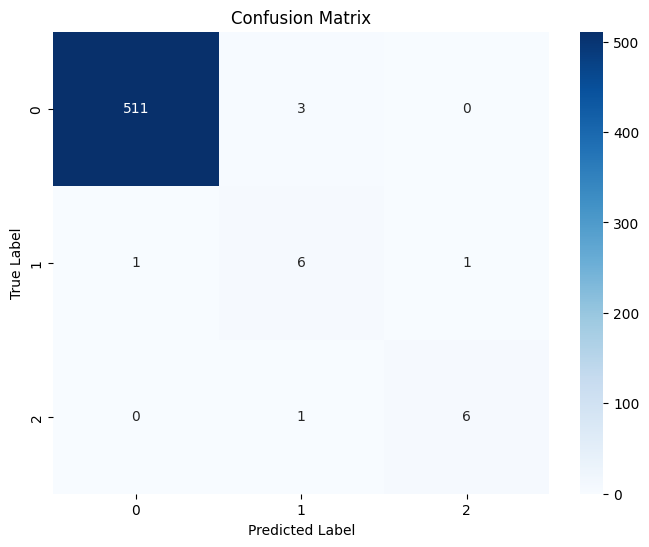

In [ ]:
X_train_best_feature = X_train[best_current_cols].copy()
X_test_best_feature = X_test[best_current_cols].copy()

sm_best_model = CatBoostClassifier(
    objective='MultiClass',
    auto_class_weights='Balanced',
    iterations=1000, # 최종 모델이므로 반복 횟수를 충분히 설정
    verbose=200,
    task_type='GPU',
    devices='0',
    **best_params
)

sm_best_model.fit(X_train_best_feature, y_train)

predictions = sm_best_model.predict(X_test_best_feature)
prediction_probs = sm_best_model.predict_proba(X_test_best_feature)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sm_best_model.classes_,
            yticklabels=sm_best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2. LightGBM 사용

## 1) 초기 구동

In [ ]:
model = lgb.LGBMClassifier(
    objective='multiclass',
    n_estimators=500,     # iterations -> n_estimators
    device='gpu',         # task_type -> device
    gpu_device_id=0,      # devices -> gpu_device_id
    random_state=42       # 결과 재현을 위한 random_state 추가 (권장)
)

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

model.fit(
    X_train,
    y_train,
    categorical_feature=cat_features,              # cat_features -> categorical_feature
    callbacks=[lgb.log_evaluation(period=100)]     # verbose -> callbacks
)
predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)
# 결과를 저장할 DataFrame 생성
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})

# 각 클래스의 확률을 별도의 컬럼으로 추가
results_df['Prob_Class_0'] = prediction_probs[:, 0]
results_df['Prob_Class_1'] = prediction_probs[:, 1]
results_df['Prob_Class_2'] = prediction_probs[:, 2]

# 영화 제목 추가 (기존 코드와 동일)
test_titles = movie_titles.loc[X_test.index]
results_df['Movie_Title'] = test_titles.values

# 결과 확인
results_df.head()

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 68087
[LightGBM] [Info] Number of data points in the train set: 2112, number of used features: 275
[LightGBM] [Info] Using GPU Device: NVIDIA L4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 271 dense feature groups (0.55 MB) transferred to GPU in 0.002578 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.027846
[LightGBM] [Info] Start training from score -4.189655
[LightGBM] [Info] Start training from score -4.397294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

,Actual,Predicted,Prob_Class_0,Prob_Class_1,Prob_Class_2,Movie_Title
1340,0,0,1.0,2.773046e-08,2.327975e-08,하울링
1385,0,0,1.0,8.892652e-08,1.793671e-08,크리미널
1231,0,0,1.0,1.125942e-08,1.364299e-08,사랑의 레시피
1225,0,0,1.0,1.016603e-08,2.136283e-08,문라이트
1894,0,0,1.0,5.418967e-08,2.591387e-08,프라미스드 랜드


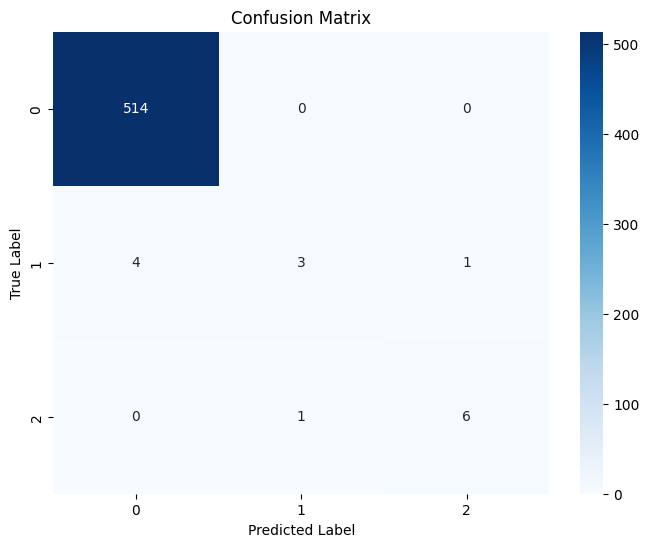

In [ ]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 2) 변수 중요도

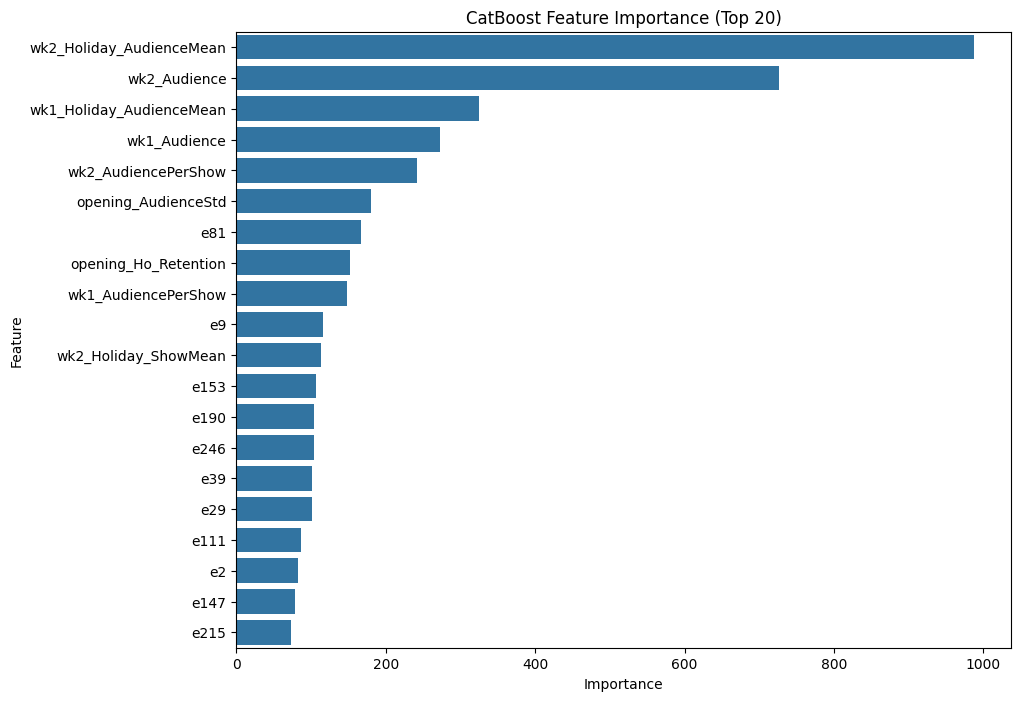

                      Feature  Importance
8    wk2_Holiday_AudienceMean         988
2                wk2_Audience         726
6    wk1_Holiday_AudienceMean         325
0                wk1_Audience         273
3         wk2_AudiencePerShow         242
10        opening_AudienceStd         180
99                        e81         167
5        opening_Ho_Retention         152
1         wk1_AudiencePerShow         148
27                         e9         116
9        wk2_Holiday_ShowMean         113
171                      e153         107
208                      e190         104
264                      e246         104
57                        e39         102
47                        e29         101
129                      e111          87
20                         e2          83
165                      e147          78
233                      e215          73


In [ ]:
# 1. 변수 중요도 추출
feature_importances = model.feature_importances_
feature_names = X_train.columns

# 2. 데이터프레임으로 만들기
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 3. 상위 20개 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance (Top 20)')
plt.show()

# 4. 중요도 출력
print(importance_df.head(20))

1. `wk2_Holiday_AudienceMean`, `wk2_Audience`
2. `wk1_Holiday_AudienceMean`, ` wk1_Audience`, `wk2_AudiencePerShow`, `opening_AudienceStd`
3. ` wk1_AudiencePerShow`, `opening_Ho_Retention`, `wk2_Holiday_ShowMean`

총 2+4+3개의 변수가 유의gnqh

## 3) 변수 선택 및 하이퍼파라미터 튜닝

In [ ]:
feature_sets = {
    "base_2": ['wk2_Holiday_AudienceMean', 'wk2_Audience'],
    "medium_6": ['wk2_Holiday_AudienceMean', 'wk2_Audience',
               'wk1_Holiday_AudienceMean', 'wk1_Audience', 'wk2_AudiencePerShow', 'opening_AudienceStd'],
    "full_9": ['wk2_Holiday_AudienceMean', 'wk2_Audience',
               'wk1_Holiday_AudienceMean', 'wk1_Audience', 'wk2_AudiencePerShow', 'opening_AudienceStd',
               'wk1_AudiencePerShow', 'opening_Ho_Retention', 'wk2_Holiday_ShowMean']
}

embedding_sets = {
    "embed_128": [f'e{i+1}' for i in range(128)],
    "embed_64": [f'e{i+1}' for i in range(64)],
    "embed_32": [f'e{i+1}' for i in range(32)],
    "embed_none" : []
}

tuner_methods = ['optuna', 'random_search']
# tuner_methods = ['random_search', 'optuna']

In [ ]:
# --- 실험 루프 ---
results = []
experiment_id = 0
total_experiments = len(feature_sets) * len(embedding_sets) * len(tuner_methods)

for f_name, f_cols in feature_sets.items():
    for e_name, e_cols in embedding_sets.items():

        # 현재 조합에 사용할 전체 변수 리스트 생성
        current_cols = f_cols + e_cols
        X_train_exp = X_train[current_cols].copy()
        X_test_exp = X_test[current_cols].copy()

        for tuner in tuner_methods:
            experiment_id += 1
            print(f"--- 실험 {experiment_id}/{total_experiments} 진행 중 ---")
            print(f"Features: {f_name}, Embeddings: {e_name}, Tuner: {tuner}")

            best_params = {}

            if tuner == 'optuna':
                def objective(trial):
                    param_optuna = {
                        'metric': 'multi_logloss',

                        'n_estimators': 300,
                        # 'n_estimators': 2,

                        'verbose': -1,
                        'device': 'gpu',
                        'gpu_device_id': 0,

                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                        'max_depth': trial.suggest_int('max_depth', 4, 10),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    }
                    model = lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', **param_optuna)
                    score = cross_val_score(model, X_train_exp, y_train, cv=3, scoring='f1_macro').mean()
                    return score

                study = optuna.create_study(direction='maximize')

                study.optimize(objective, n_trials=40, show_progress_bar=True)
                # study.optimize(objective, n_trials=2, show_progress_bar=True)

                best_params = study.best_params

            elif tuner == 'random_search':
                param_random = {
                    'learning_rate': uniform(0.01, 0.29),
                    'num_leaves': randint(20, 301),
                    'max_depth': randint(4, 11),
                    'subsample': uniform(0.6, 0.4),
                    'colsample_bytree': uniform(0.6, 0.4),
                    'reg_alpha': uniform(1, 9),
                    'reg_lambda': uniform(1, 9),
                    'min_child_samples': randint(5, 101),
                }

                model = lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', n_estimators=300, verbose=-1, device='gpu', gpu_device_id=0)
                # model = lgb.LGBMClassifier(objective='multiclass', class_weight='balanced',n_estimators=2, verbose=-1, device='gpu', gpu_device_id=0)

                random_search = RandomizedSearchCV(
                    model,
                    param_distributions=param_random,

                    n_iter=40,
                    # n_iter=2,

                    cv=3,
                    scoring='f1_macro',
                    random_state=42,
                    verbose=1,
                )
                random_search.fit(X_train_exp, y_train)
                best_params = random_search.best_params_

            # 찾은 최적의 파라미터로 최종 모델 학습
            print(f"{f_name} - {e_name} - {tuner} 최종 모델 학습")
            final_model = lgb.LGBMClassifier(
                objective='multiclass',
                class_weight='balanced',

                n_estimators=1000,
                # n_estimators=2,

                device='gpu',
                gpu_device_id=0,
                **best_params
            )
            # fit 할 때 로그 출력 설정 (callbacks)
            final_model.fit(X_train_exp, y_train, callbacks=[lgb.log_evaluation(period=200)])

            # 테스트 데이터로 성능 평가
            preds = final_model.predict(X_test_exp)
            f1 = f1_score(y_test, preds, average='macro')
            detailed_metrics = calculate_multiclass_metrics(y_test, preds)

            # 결과 저장
            result_row = {
                "Experiment_ID": experiment_id,
                "Feature_Set": f_name,
                "Embedding_Set": e_name,
                "Tuner": tuner,
                "Test_F1_Macro": f1,
                "Best_Params": best_params
            }
            result_row.update(detailed_metrics)
            results.append(result_row)
            print(f"결과 - F1 Macro: {f1:.4f}\n")

--- 실험 1/24 진행 중 ---
Features: base_2, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7713

--- 실험 2/24 진행 중 ---
Features: base_2, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.7900

--- 실험 3/24 진행 중 ---
Features: base_2, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7600

--- 실험 4/24 진행 중 ---
Features: base_2, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.7565

--- 실험 5/24 진행 중 ---
Features: base_2, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7193

--- 실험 6/24 진행 중 ---
Features: base_2, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.7838

--- 실험 7/24 진행 중 ---
Features: base_2, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.7838

--- 실험 8/24 진행 중 ---
Features: base_2, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.7690

--- 실험 9/24 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7713

--- 실험 10/24 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.7673

--- 실험 11/24 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7952

--- 실험 12/24 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.7983

--- 실험 13/24 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7600

--- 실험 14/24 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.7922

--- 실험 15/24 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.8650

--- 실험 16/24 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.8543

--- 실험 17/24 진행 중 ---
Features: full_9, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7952

--- 실험 18/24 진행 중 ---
Features: full_9, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.8396

--- 실험 19/24 진행 중 ---
Features: full_9, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.8135

--- 실험 20/24 진행 중 ---
Features: full_9, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.8511

--- 실험 21/24 진행 중 ---
Features: full_9, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.7713

--- 실험 22/24 진행 중 ---
Features: full_9, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.8511

--- 실험 23/24 진행 중 ---
Features: full_9, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.7952

--- 실험 24/24 진행 중 ---
Features: full_9, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.8447



In [ ]:
# --- 4. 최종 결과 취합 및 출력 ---
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Test_F1_Macro', ascending=False)

print("========== 최종 실험 결과 (F1 Score 기준 정렬) ==========")
results_df_sorted.head()

========== 최종 실험 결과 (F1 Score 기준 정렬) ==========


,Experiment_ID,Feature_Set,Embedding_Set,Tuner,Test_F1_Macro,Best_Params,Precision_Class_0,Recall_Class_0,Specificity_Class_0,Precision_Class_1,Recall_Class_1,Specificity_Class_1,Precision_Class_2,Recall_Class_2,Specificity_Class_2
14,15,medium_6,embed_none,optuna,0.865041,"{'learning_rate': 0.2902270639724662, 'num_lea...",0.998043,0.992218,0.933333,0.600000,0.750,0.992322,0.875000,1.000000,0.998084
15,16,medium_6,embed_none,random_search,0.854280,"{'colsample_bytree': 0.7942455014344907, 'lear...",1.000000,0.986381,1.000000,0.500000,0.875,0.986564,0.875000,1.000000,0.998084
19,20,full_9,embed_64,random_search,0.851079,"{'colsample_bytree': 0.786705157299192, 'learn...",1.000000,0.992218,1.000000,0.583333,0.875,0.990403,0.857143,0.857143,0.998084
21,22,full_9,embed_32,random_search,0.851079,"{'colsample_bytree': 0.7942455014344907, 'lear...",1.000000,0.992218,1.000000,0.583333,0.875,0.990403,0.857143,0.857143,0.998084
23,24,full_9,embed_none,random_search,0.844729,"{'colsample_bytree': 0.786705157299192, 'learn...",1.000000,0.984436,1.000000,0.466667,0.875,0.984645,0.875000,1.000000,0.998084


## 4) 최종 모델 생성

In [ ]:
# --- 5. 최고 성능 모델 재학습 및 저장 (LightGBM 버전) ---
print("\n========== 최고 성능 모델 재학습 및 저장 ==========")

# 5-1. 가장 점수가 높았던 실험의 설정 가져오기
best_experiment = results_df_sorted.iloc[0]
best_f_name = best_experiment['Feature_Set']
best_e_name = best_experiment['Embedding_Set']
best_params = best_experiment['Best_Params']

print(f"최고 성능 조합: Features='{best_f_name}', Embeddings='{best_e_name}'")
print(f"최고 성능 하이퍼파라미터: {best_params}")

# 5-2. 최고 성능 조합에 맞는 전체 데이터 준비
best_f_cols = feature_sets[best_f_name]
best_e_cols = embedding_sets[best_e_name]
best_current_cols = best_f_cols + best_e_cols

# 전체 데이터 X에서 최고 성능의 변수들만 선택
X_best_features = X[best_current_cols].copy() # .copy() 추가

# 5-3. 최고 성능 파라미터로 최종 모델 생성
best_model = lgb.LGBMClassifier(
    objective='MultiClass',
    auto_class_weights='Balanced',

    n_estimators=1000,
    device='gpu',
    gpu_device_id=0,
    **best_params
)

print("\n최고 성능 모델 전체 데이터로 재학습 시작...")
# 전체 데이터(X_best_features, y)로 최종 학습
best_model.fit(
    X_best_features,
    y,
    callbacks=[lgb.log_evaluation(period=200)] # verbose -> callbacks
)
print("재학습 완료.")

# 5-4. 모델 파일로 저장 (★★ LightGBM 핵심 부분 ★★)
# .booster_ 속성을 통해 LightGBM의 핵심 모델에 접근하여 저장합니다.
best_model.booster_.save_model("/content/drive/MyDrive/비어플/25-2/model/lightgbm_model_5m.txt")
print("최고 성능 모델을 'lightgbm_model_10k.txt' 파일로 저장했습니다. 💾")


========== 최고 성능 모델 재학습 및 저장 ==========
최고 성능 조합: Features='medium_6', Embeddings='embed_none'
최고 성능 하이퍼파라미터: {'learning_rate': 0.2902270639724662, 'num_leaves': 295, 'max_depth': 7, 'subsample': 0.7794092079790117, 'colsample_bytree': 0.7561910521805562, 'reg_alpha': 0.39739004576253223, 'reg_lambda': 0.0014459807475821593, 'min_child_samples': 17}

최고 성능 모델 전체 데이터로 재학습 시작...
재학습 완료.
최고 성능 모델을 'lightgbm_model_10k.txt' 파일로 저장했습니다. 💾


## 시각화

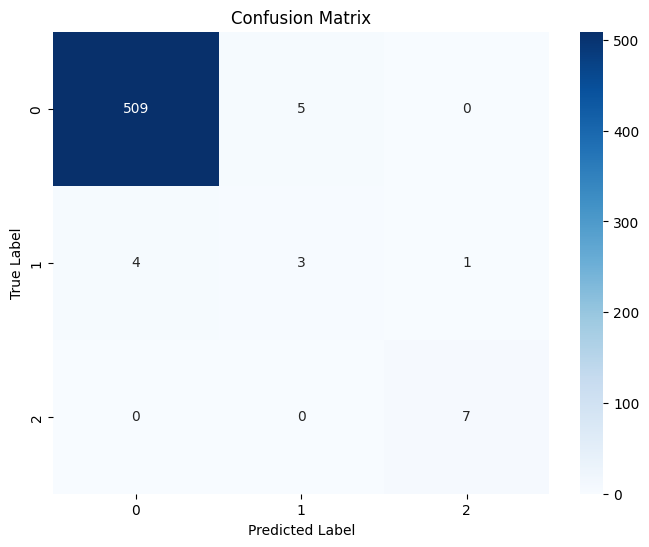

In [ ]:
X_train_best_feature = X_train[best_current_cols].copy()
X_test_best_feature = X_test[best_current_cols].copy()

sm_best_model = lgb.LGBMClassifier(
    objective='MultiClass',
    auto_class_weights='Balanced',

    n_estimators=1000,
    device='gpu',
    gpu_device_id=0,
    **best_params
)

sm_best_model.fit(
    X_train_best_feature,
    y_train,
    callbacks=[lgb.log_evaluation(period=200)] # verbose -> callbacks
)

predictions = sm_best_model.predict(X_test_best_feature)
prediction_probs = sm_best_model.predict_proba(X_test_best_feature)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sm_best_model.classes_,
            yticklabels=sm_best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()